In [1]:
import numpy as np
from scipy.linalg import svd, eig, inv
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

# Vortex generator

The goal of this notebook is to generate a database for demonstration of POD to undergraduate students. For this, a synthetic Burgers-Rott-type vortex is simulated using the following analytical expression for the vorticity field:

$$ f(x,y,t)=\frac{1}{2\pi \sigma^{2}}e^{-\frac{x-x_{0}}{2\sigma}-\frac{y-y_{0}}{2\sigma}} $$

In the equation, $x_{0}$ and $y_{0}$ denote the coordinates of the center of the vortex and $\sigma$ represents its diameter. To simulate translational motion, the coordinates $x_{0}$ and $y_{0}$ vary randomly around a pre established point at each time step. In addition, $\sigma$ is implemented in the form of a periodic function to modify the size of the vortex over time.

The 2D mesh consists of 51x51 elements. The data matrix $M$ is created in order to contain the vectorized snapshots in its columns. The number of snapshots can be set in the code. For the mesh created and a number of snapshots equal to 60, we should expect the data matrix to be $M_{2601 \times 60}$.

In the cell below the functions for creating the vortex are declared. The function _vortex_ calls the functions _sigma_vortex_, which implements the pulse, and _linear_trajectory_, which defines a linear path and is optional (not recommended for POD analysis).

In [2]:
# Use linear trajectory for the translation of the vortex
def linear_trajectory(p0, t):
    v = 1
    return p0 + v*t

# Sigma function to change the vortex diameter
def sigma_vortex(sigma0, amplitude, vortex_freq, t):    
    return sigma0 + amplitude*np.sin(vortex_freq*t)

# Burgers-Rott model
def vortex(x, y, x0, y0, sigma0, amplitude, vortex_freq, t):
    #x0 = linear_trajectory(10, t)
    #y0 = linear_trajectory(10, t)
    
    # Use this line to implement pulse
    sigma = sigma_vortex(sigma0, amplitude, vortex_freq, t)
    
    # Use this line to generate vortex with constant diameter
    #sigma = sigma0
    
    return 1/(2*np.pi*sigma**2)*np.exp(-(x - x0)**2/(2*sigma) - (y - y0)**2/(2*sigma))

The vortex parameters are set in the next cell. 

* _p0_ defines the center of the vortex. The coordinates $x_{0}, y_{0}$ are obtained from it. 
* _p0_std_ sets the standard deviation of the coordinates. 
* The initial diameter of the vortex is defined by _sigma0_ while the amplitude and frequency of its pulse are defined by _amplitude_ and _vortex_freq_, respectivelly.
* The grid is generated as a  $n\times n$ squared mesh. The number of elements $n$ is set by _grid_size_
* _duration_ represents the number of snaphots of the database

In [3]:
## Modify here --------------------------------

# Setting vortex parameters 
p0 = 25 # This is the central point of the vortex (should be near the middle of the mesh)
p0_std = 1 # Indicates how much the vortex will move
sigma0 = 75 # Initial vortex diameter
amplitude = 5 # Amplitude of periodic function for diameter pulse
vortex_freq = 1 # Frequency of pulse

# Creating mesh
grid_size = 51
duration = 60 # Number of snapshots

# Save file
filename = 'vortex_example'

#----------------------------------------------

x = np.arange(0, grid_size)
y = np.arange(0, grid_size)
time = np.arange(0, duration)

# Generating database
X = np.ones((grid_size, grid_size)) # Snapshot matrix
M = np.ones((grid_size**2, len(time))) # Data matrix containing set of snapshots

for k in range(len(time)):
    x0 = round(np.random.normal(p0, p0_std))
    y0 = round(np.random.normal(p0, p0_std))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i,j] = vortex(x[i], y[j], x0, y0, sigma0, amplitude, vortex_freq, time[k])
            X_reshaped = X.flatten()
            M[:,k] = X_reshaped

# Save database in CSV format
pd.DataFrame(M).to_csv(filename+'.csv', index=False, header=False)

## The Proper Orthogonal Decomposition (POD)

The Proper Orthogonal Decomposition (POD) is a technique for representing data on an orthogonal basis as the sum of a series of modes. In fluid mechanics, this method is widely applied in the analysis of velocity fields. The data matrix is formed by the vertical and horizontal components of the velocity at different points of the flow visualization window or the mesh of a CFD simulation. 

The POD modes are formed by the product of the dominant patterns observed in a flow field times the time series describing their respective evolutions. The proper orthogonal decomposition of a random vector field is often describe as:

$$ \mathbf{u}(\mathbf{x}, t) = \mathbf{\overline U}(\mathbf{x}, t) + \sum \limits _{k = 1}^{\infty} a_{k}(t) \mathbf{\Phi_{k}}(\mathbf{x}) $$

Where $\mathbf{u}(\mathbf{x}, t)$ represents the velocity field, $\mathbf{\overline U}(\mathbf{x}, t)$ is the mean flow and $\mathbf{x}=(x,y,z)$ is the spatial coordiante system. The POD spatial modes are denoted by $\mathbf{\Phi_{k}}(\mathbf{x})$ and $a_{k}(t)$are the temporal coefficients.

The POD can be obtained through a simple eigenvalue and eigenvector problem. Since the POD is a special case of the Singular Value Decomposition (SVD), we can treat it as such. If the basis of the data is orthogonal, which is often the case when analyzing a velocity field, we can find the spatial modes and the temporal coefficients through the data correlation matrix $\mathbf{C}$ obtained as follows:

$$ \mathbf{C} = \mathbf{X^{T}} \mathbf{X} $$

From now on, to be in line with the literature on this topic, we will denote the velocity field matrix as $\mathbf{X}_{nxm}$ ($n > m$). Its SVD can be written as:

$$ \mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V^{T}} $$

Where $\mathbf{U}$ is $nxn$ and contains the dominant spatial patterns of the data; $\mathbf{\Sigma}$, which represents the energy of the spatial modes, is an non-negative diagonal $nxm$ matrix with the eigenvalues of $\mathbf{X}$ sorted in decreasing order; and $\mathbf{V^{T}}$ is $mxm$ and can be understood as the time series of the respective modes. Since $\mathbf{\Sigma}$ is diagonal and has only $m$ eigenvalues, we can write the above equation as:

$$ \mathbf{X} = \hat{\mathbf{U}} \hat{\mathbf{\Sigma}} \mathbf{V^{T}} $$

For $\hat{\mathbf{U}}_{mxm}$ and  $\hat{\mathbf{\Sigma}}_{mxm}$. We call this the _economy_ SVD. Truncating the matrices reduces the cost of operations involving them. One of the interests of modal analysis in the study of velocity fields is the fact that we can truncate the SVD on the $r^{th}$ element to get a good approximation of the real flow, as it is stated by the Eckand-Young theorem (1936). The reconstructed velocity field $\tilde{\mathbf{X}}$ can be written as:

$$ \tilde{\mathbf{X}} = \tilde{\mathbf{U}} \tilde{\mathbf{\Sigma}} \mathbf{\tilde{V}^{T}} $$

Now only the columns that correspond to the $r$ modes are considered. It is common to truncate the matrices when the accumulated energy of the modes is considered sufficient to describe the original data with the desired accuracy.

<IPython.core.display.Javascript object>


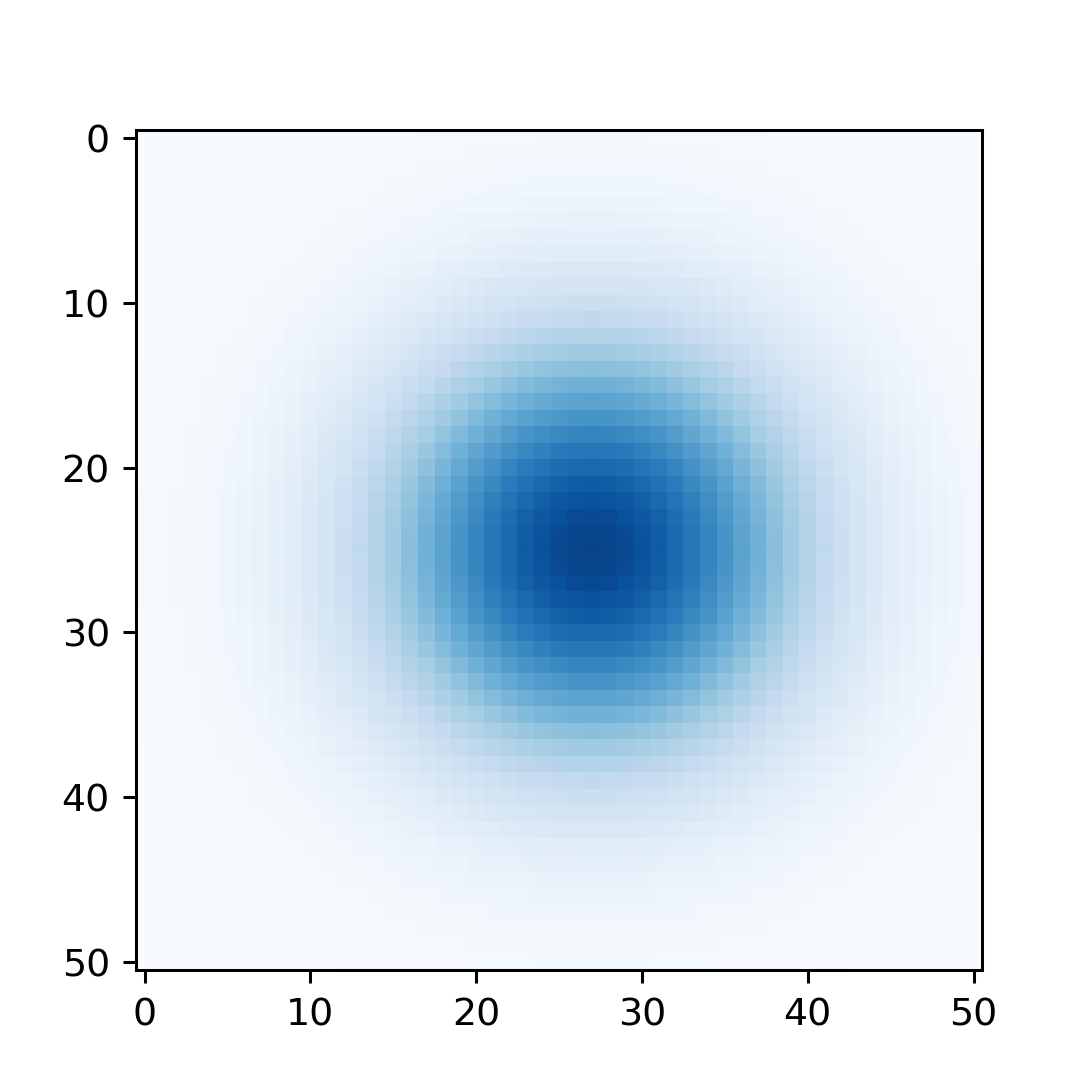

In [4]:
df = pd.read_csv('vortex_example.csv', header=None) # Testing the CSV file generated previously

M = df.values

# Create animation from snapshots
fps = 10
nSeconds = 10
snapshots = []

for j in range(M.shape[1]):
    snapshots.append(np.reshape(M[:,j], (grid_size, grid_size)))

plt.rcParams['animation.ffmpeg_path'] = r'C:\\Users\\mateu\\Desktop\\ffmpeg\\bin\\ffmpeg.exe'
fig = plt.figure(figsize=(4,4))
a = snapshots[0]
im = plt.imshow(a, interpolation='none', aspect='auto', cmap=plt.cm.Blues)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames=nSeconds*fps, interval=1000/fps)

#anim.save('vortex_animation.gif', fps=fps)

Now the SVD will be used to obtain the spatial modes contained in the matrix $U$. The Python function generates the eigenvalues in the form of a vector, not a diagonal matrix. When dealing with fluid flows, the first POD mode, here called mode 0, usually corresponds to the mean flow. Therefore it is common for it to stand out in the energy distribution. It is common for this mode to be neglected when analyzing only the turbulent component of the system.

Dimensions of U:
(2601, 2601)

Dimensions of Sigma:
(60,)

Dimensions of transposed V:
(60, 60)


<IPython.core.display.Javascript object>


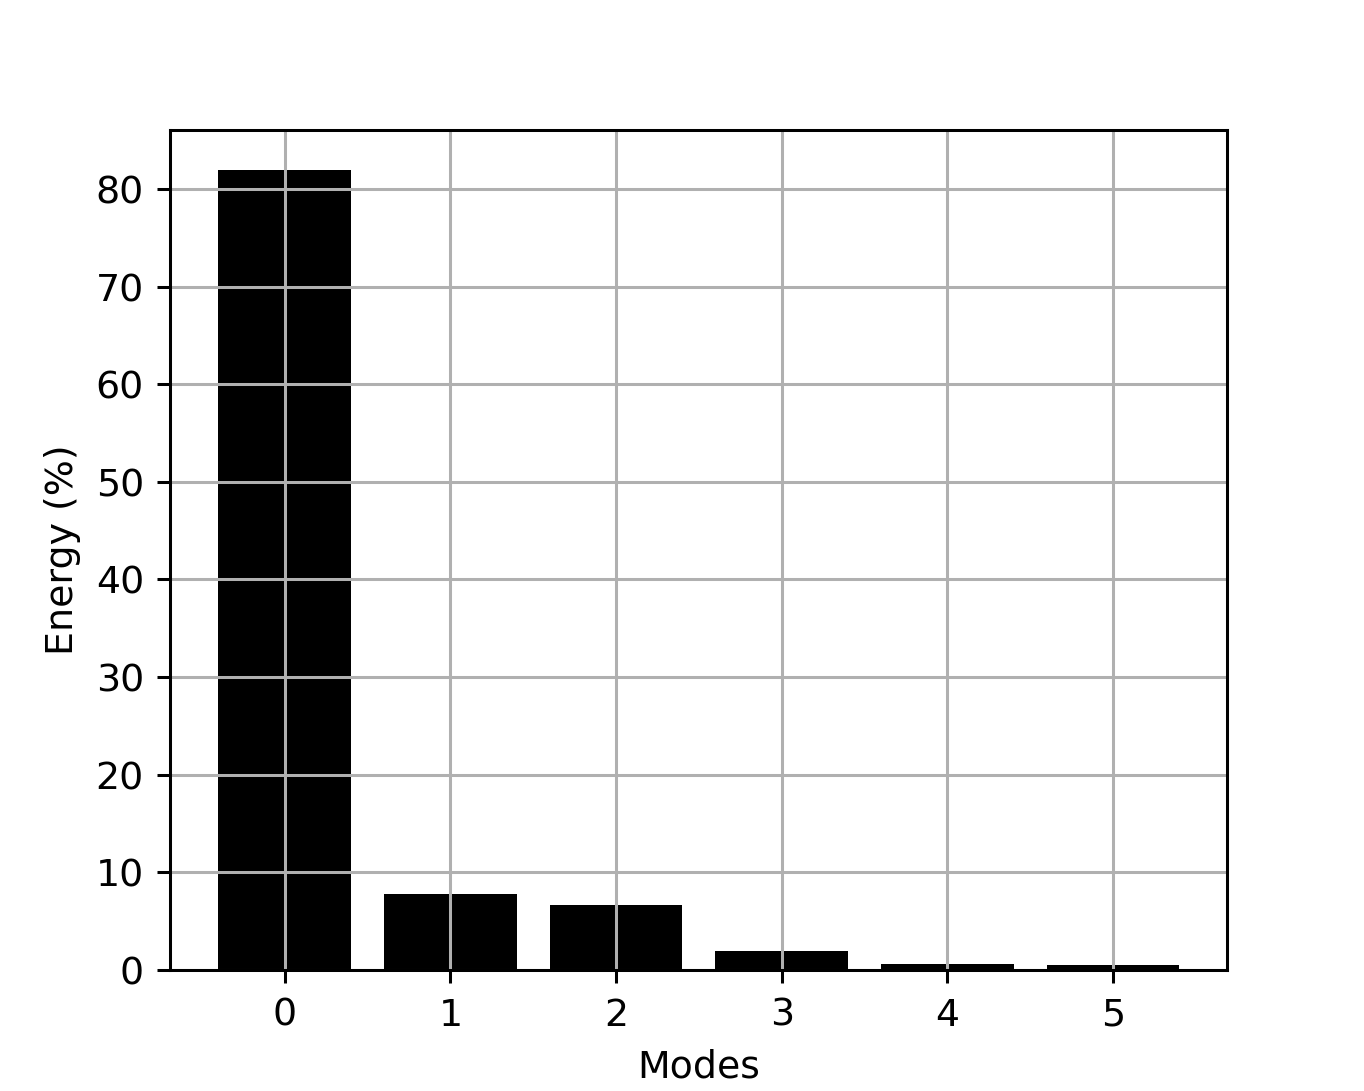

<IPython.core.display.Javascript object>


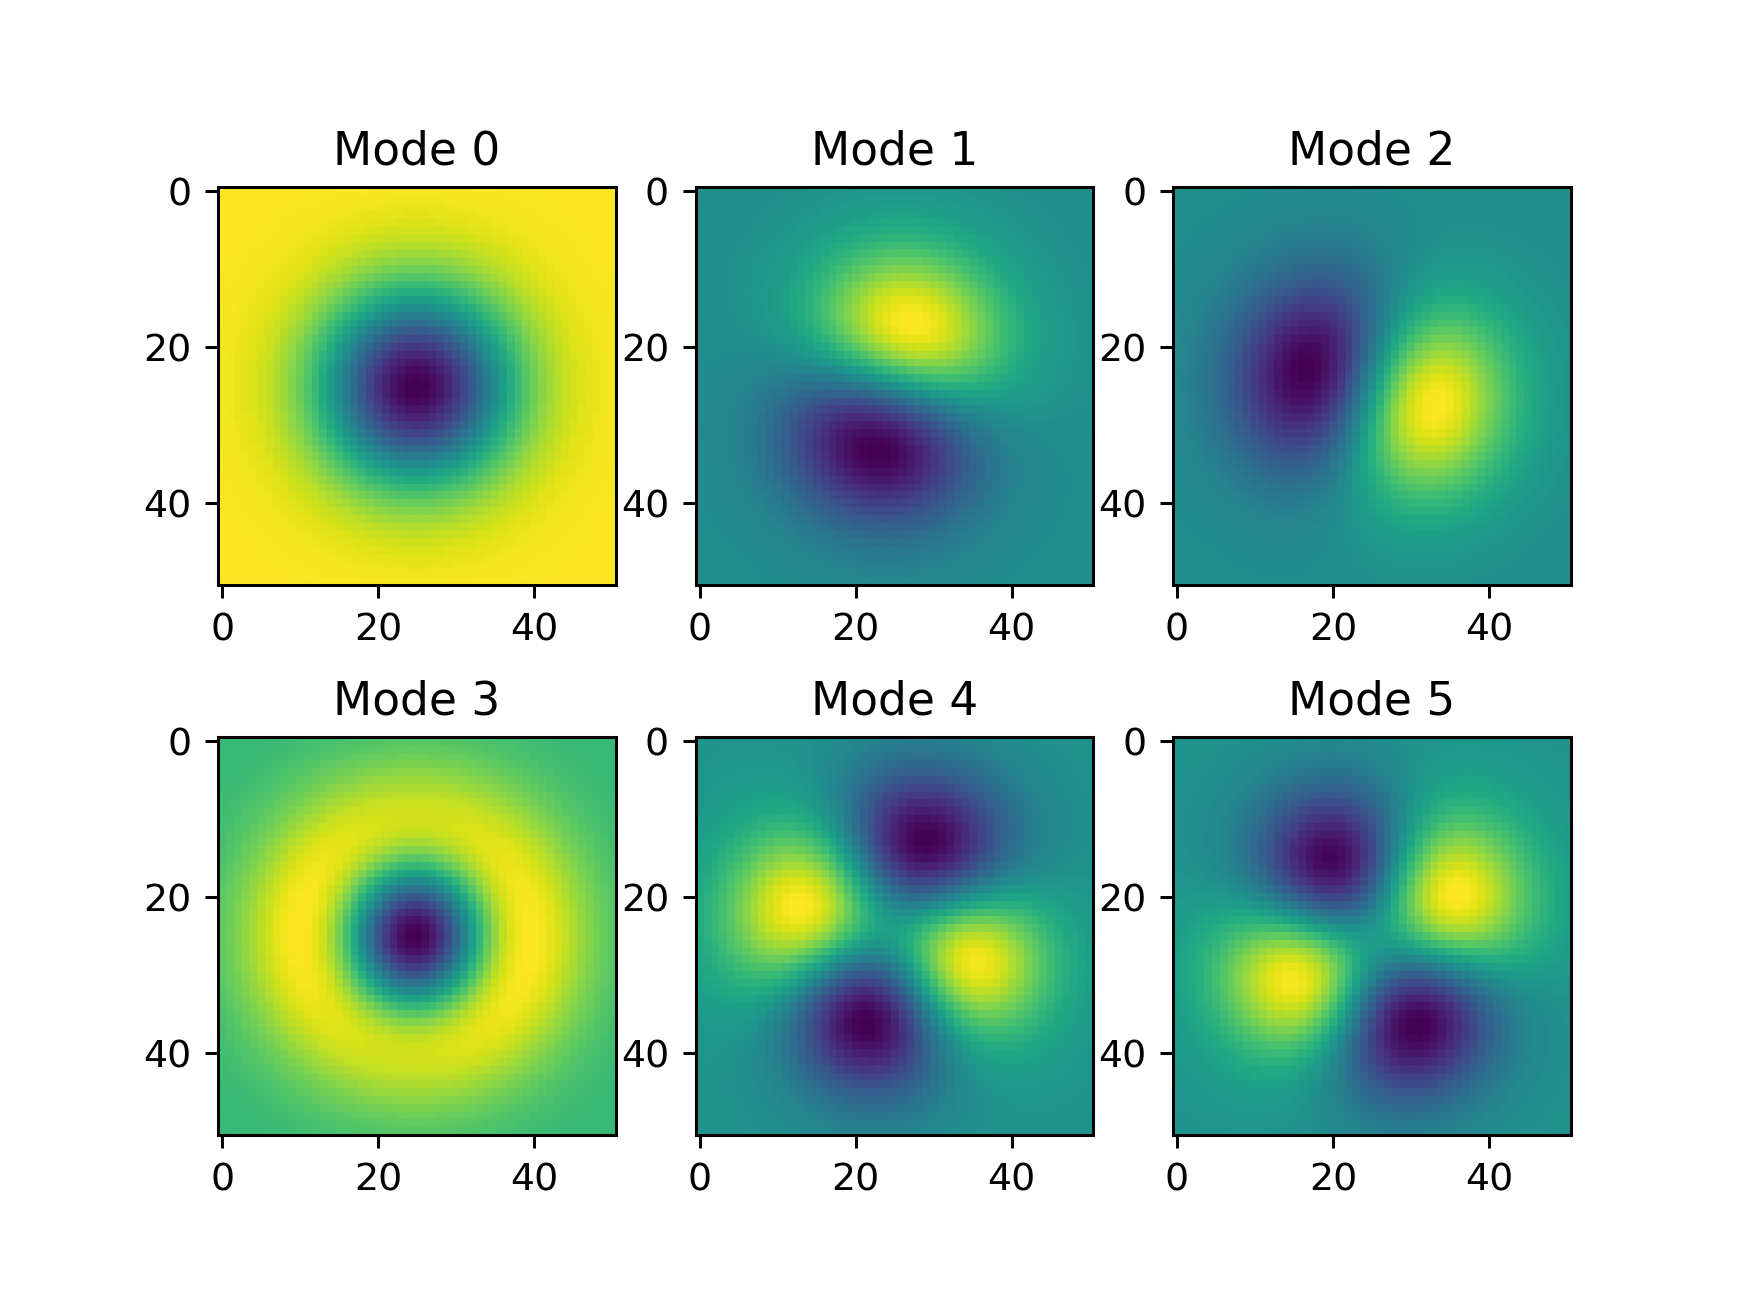

In [5]:
U, s, Vt = svd(M)

print('Dimensions of U:')
print(U.shape)
print('')
print('Dimensions of Sigma:')
print(s.shape)
print('')
print('Dimensions of transposed V:')
print(Vt.shape)

plt.figure(figsize=(5, 4))
plt.bar(np.arange(len(s[:6])), s[:6]/s.sum()*100, color='black')
plt.xlabel('Modes')
plt.xticks(np.arange(len(s[:6])), ['0', '1', '2', '3', '4', '5'])
plt.ylabel('Energy (%)')
plt.grid()
plt.show()

mode00 = np.reshape(U[:,0], (grid_size, grid_size))
mode01 = np.reshape(U[:,1], (grid_size, grid_size))
mode02 = np.reshape(U[:,2], (grid_size, grid_size))
mode03 = np.reshape(U[:,3], (grid_size, grid_size))
mode04 = np.reshape(U[:,4], (grid_size, grid_size))
mode05 = np.reshape(U[:,5], (grid_size, grid_size))

fig, axs = plt.subplots(2,3)
axs[0,0].imshow(mode00)
axs[0,0].set_title('Mode 0')
axs[0,1].imshow(mode01)
axs[0,1].set_title('Mode 1')
axs[0,2].imshow(mode02)
axs[0,2].set_title('Mode 2')
axs[1,0].imshow(mode03)
axs[1,0].set_title('Mode 3')
axs[1,1].imshow(mode04)
axs[1,1].set_title('Mode 4')
axs[1,2].imshow(mode05)
axs[1,2].set_title('Mode 5')
plt.show()